# The ``lineup()`` plan - align an axis with a signal

In this example, we demonstrate the `apstools.plans.lineup()` plan, which aligns
an axis using some statistical measure (`cen`: centroid, `com`: center of mass,
`max`: position of peak value, or even `min`: negative trending peaks) of a
signal.  If an alignment is possible, an optional rescan will fine-tune the
alignment within the width and center of the first scan.  Use `rescan=False`
keyword to disable.  Here's an example chart showing the first (roughly, locate
at least one point **within** the peak) and second (fine-tune the position)
scans.

![Chart of example lineup showing first and second scans.](lineup.png)

We'll use a floating-point scalar value (not connected to hardware) as a
*positioner*.  Then, we prepare a simulated *detector* signal that is a
computation based on the value of our positioner.  The computed signal is a
model of a realistic diffraction peak
([pseudo-Voigt](https://en.wikipedia.org/wiki/Voigt_profile), a mixture of a
Gaussian and a Lorentzian) one might encounter in a powder diffraction scan.
The model peak is a pseudo-voigt function to which some noise has been added.
Random numbers are used to modify the ideal pseudo-voigt function so as to
simulate a realistic signal.

For this demo, we'll use a temporary databroker catalog (deleted when the
notebook is closed) since we do not plan to review any of this data after
collection.  We'll display the data during the scan(in both a table and a chart)
using a `BestEffortCallback()` subscription to the `bluesky.RunEngine()`.

In [1]:
from apstools.devices import SynPseudoVoigt
from apstools.plans import lineup
from apstools.tests import IOC
from bluesky import RunEngine
from bluesky.callbacks import best_effort
import bluesky.plan_stubs as bps
import databroker
import numpy
import ophyd

bec = best_effort.BestEffortCallback()
cat = databroker.temp()
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(bec)

1

## Setup

Set the IOC prefix and connect with our EPICS PVs.

In [2]:
IOC = "gp:"
axis = ophyd.EpicsSignal(f"{IOC}gp:float1", name="axis")

axis.wait_for_connection()

Once connected, create the *detector* signal (the computed pseudo-Voigt) with default peak parameters.

In [3]:
# Need to know that axis is connected before using here.
pvoigt = SynPseudoVoigt(name="pvoigt", motor=axis, motor_field=axis.name)

The `pvoigt` signal must have `kind="hinted"` for it to appear in tables and plots.

In [4]:
pvoigt.kind = "hinted"

Move `axis` to a starting position.  Pick zero.

In [5]:
RE(bps.mv(axis, 0))

()

## Scan

To make things interesting, first randomize the peak parameters.  (Peak is placed randomly between -1..+1 on `axis` scale, with random width, scale, pseudo-Voigt mixing parameter, noise, ...)

In [6]:
pvoigt.randomize_parameters(scale=100_000)

Run the `lineup()` plan through the range where the peak is expected.  Don't need many points to catch some value that is acceptable (max is more than 4*min) the background.



Transient Scan ID: 1     Time: 2022-09-28 15:35:18
Persistent Unique Scan ID: '22182d47-72c1-450b-bf62-035a2c608d11'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |       axis |     pvoigt |
+-----------+------------+------------+------------+
|         1 | 15:35:18.6 |    -1.2000 |       1413 |
|         2 | 15:35:18.6 |    -1.0000 |       5259 |
|         3 | 15:35:18.7 |    -0.8000 |      55856 |
|         4 | 15:35:18.7 |    -0.6000 |       2113 |
|         5 | 15:35:18.7 |    -0.4000 |       1070 |
|         6 | 15:35:18.8 |    -0.2000 |        796 |
|         7 | 15:35:18.8 |     0.0000 |        689 |
|         8 | 15:35:18.8 |     0.2000 |        675 |
|         9 | 15:35:18.8 |     0.4000 |        600 |
|        10 | 15:35:18.8 |     0.6000 |        649 |
|        11 | 15:35:18.9 |     0.8000 |        567 |
|        12 | 15:35:18.9 |     1.0000 |        547 |
|        13 | 15:35:18.9 |     1.2000 |        552 |
+----------

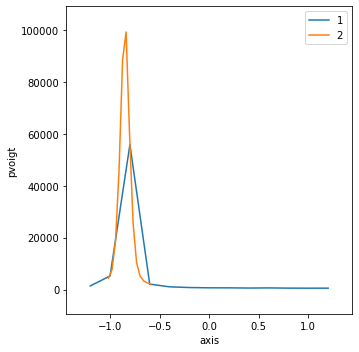

In [7]:
RE(lineup(pvoigt, axis, -1.2, 1.2, 13, feature="cen", rescan=True))
print(f"{pvoigt.read()=}, {axis.get()=}")

## Validate

Show the position after the `lineup()` completes.  Test (Python `assert`) that it is within the expected range.

In [8]:
center = pvoigt.center
sigma = 2.355 * pvoigt.sigma
print(f"{center=}\n{sigma=}\n{bec.peaks=}")
assert center-sigma <= axis.get() <= center+sigma

center=-0.8503901139652472
sigma=0.11456520969899238
bec.peaks={
'com':
    {'pvoigt': -0.8461974129441658}
,
'cen':
    {'pvoigt': -0.8496701712914874}
,
'max':
    {'pvoigt': (-0.8385705807871623,
                99186)}
,
'min':
    {'pvoigt': (-0.5909727956676526,
                2046)}
,
'fwhm':
    {'pvoigt': 0.11177564414922392}
,
}
